In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'tensorflow'

In [7]:
TRAIN_PATH = '/content/drive/MyDrive/dataset/currency'

In [22]:
import os
takas = os.listdir(TRAIN_PATH)
takas = takas[0:]
takas

['100', '500', '10', '20', '5', '2', '50', '1', '1000', '200']

In [23]:
import os

num_skipped = 0
for folder_name in takas:
    folder_path = os.path.join(TRAIN_PATH, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [24]:
image_size = (250, 120)
batch_size = 128

train_ds= tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds= tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)



Found 1697 files belonging to 10 classes.
Using 1358 files for training.
Found 1697 files belonging to 10 classes.
Using 339 files for validation.


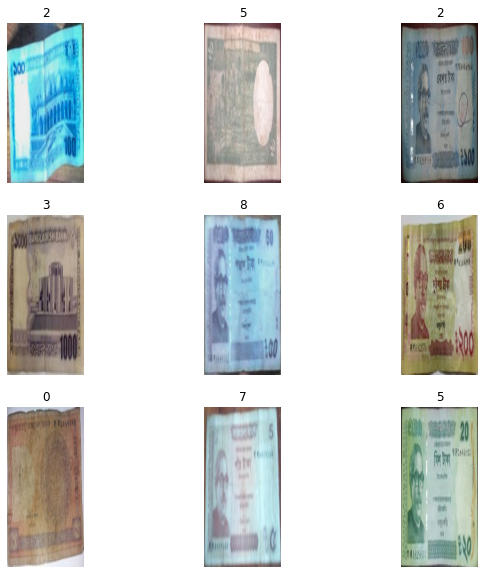

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

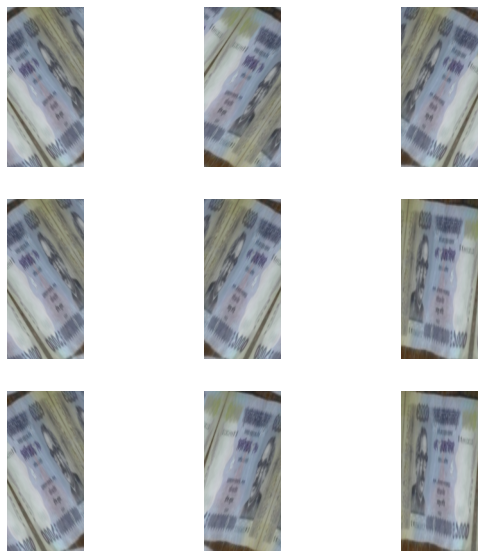

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [28]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [29]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [30]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16
#from keras.preprocessing import image

IMAGE_SIZE = [250, 120]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
#x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
x = Dense(10, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 60, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 60, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 60, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 30, 128)       0   

In [33]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
11/11 [==============================] - 11s 772ms/step - loss: 1.2262 - accuracy: 0.8336 - val_loss: 1.5350 - val_accuracy: 0.8260
Epoch 2/10
11/11 [==============================] - 10s 762ms/step - loss: 0.5469 - accuracy: 0.9116 - val_loss: 0.8611 - val_accuracy: 0.8909
Epoch 3/10
11/11 [==============================] - 10s 757ms/step - loss: 0.3206 - accuracy: 0.9330 - val_loss: 0.8183 - val_accuracy: 0.8850
Epoch 4/10
11/11 [==============================] - 10s 757ms/step - loss: 0.2641 - accuracy: 0.9448 - val_loss: 0.9999 - val_accuracy: 0.9027
Epoch 5/10
11/11 [==============================] - 10s 776ms/step - loss: 0.2257 - accuracy: 0.9529 - val_loss: 0.7771 - val_accuracy: 0.8997
Epoch 6/10
11/11 [==============================] - 10s 772ms/step - loss: 0.1923 - accuracy: 0.9558 - val_loss: 0.4394 - val_accuracy: 0.9499
Epoch 7/10
11/11 [==============================] - 11s 778ms/step - loss: 0.1441 - accuracy: 0.9742 - val_loss: 0.3733 - val_accuracy: 0.9528

In [44]:
currency = ["1", "10", "100", "1000", "2", "20", "200", "5", "50", "500"]

In [121]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/dataset/testing/0.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

predictions.argmax()
currency[predictions.argmax()]



1/1 [==============================] - 0s 17ms/step


'100'